In [52]:
import pyawr.mwoffice as mwo

import numpy as np
from numpy.polynomial.polynomial import polyfit

import matplotlib.pyplot as plt

import qkit.analysis.circle_fit.circle_fit_2019.circuit as cf

#***PICK ONE***
#Agg rendering embedded in a Jupyter widget. (inline) Requires ipympl:
# %matplotlib ipympl 
#Agg rendering to a Tk canvas (new window) Requires TkInter:
# %matplotlib tk 

In [53]:
awrde = mwo.CMWOffice() #Create awrde object
awrde.Project.Simulator.Analyze() #In/voke circuit simulator analysis

In [54]:
def reset_freqs (l_bnd=4e9, u_bnd=8e9, steps=10000):
    '''
    Reset the MWO project frequencies.

    returns an array running from 
    lower_bound to upper_bound in steps steps.
    '''
    
    awrde.Project.Frequencies.Clear() # clear the frequencies specified for the project
    freq_arr = np.linspace(l_bnd, u_bnd, steps)
    awrde.Project.Frequencies.AddMultiple(freq_arr) # add the frequencies in the passed frequency array

    awrde.Project.Simulator.Analyze() # must run this every time after setting or changing things in MWO project!

    return freq_arr

In [55]:
def set_circ_params(circ_name='Sample_Subcircuit', get_params=False, **kwargs): 
    '''Sets specified circuit parameters in circuit called circ_name.
    

    If you attempt to pass a parameter that doesn't exit in the circuit called circ_name, 
    MWO will throw an error.

    Returns a dictionary with the new values.
    '''

    passed_circ_param_vals = { # dictionary of subcircuit element parameter values (e.g. the value of the capacitor (element's) capacitance (parameter.))
        'CAP': awrde.Project.Schematics(circ_name).Elements(1).Parameters(2).ValueAsDouble,
        'IND': awrde.Project.Schematics(circ_name).Elements(2).Parameters(2).ValueAsDouble,
        'RES': awrde.Project.Schematics(circ_name).Elements(3).Parameters(2).ValueAsDouble
    }
    passed_circ_params = { # dictionary of subcircuit component 
        'CAP': awrde.Project.Schematics(circ_name).Elements(1).Parameters(2),
        'IND': awrde.Project.Schematics(circ_name).Elements(2).Parameters(2),
        'RES': awrde.Project.Schematics(circ_name).Elements(3).Parameters(2)
    }

    # print("DEBUG: Setting:" + kwargs.__str__())

    new_circ_param_vals = {**passed_circ_param_vals, **kwargs} # in the case of duplicate keys, only the later key-value pair is preserved
    # print("DEBUG: new parameters:" + new_circ_param_vals.__str__())

    for i, value in enumerate(new_circ_param_vals.values()):
        list(passed_circ_params.values())[i].ValueAsDouble = value # in python3, dict.keys(), .values(), and .items() return dynamically changing view objects, but not the objects themselves. Hence, list().

        # print("DEBUG: " + list(passed_circ_param_vals)[i] + " set to " + str(value))
    
    if not(get_params):
        awrde.Project.Simulator.Analyze() # must run this every time after setting or changing things in MWO project!

    return new_circ_param_vals

In [56]:
def create_polar_graph(schem_name='Hanger_Test'):
    graphs = awrde.Project.Graphs
    # TODO: Name helper graph appropriately
    graph = graphs.Add("CalcHelper {}".format(schem_name), mwo.mwGraphType.mwGT_Polar)

    graph.Measurements.Add(schem_name, 'S(2,1)')

    return graph

In [57]:
def delete_graph(graph=None):
    for i in range(awrde.Project.Graphs.Count):
        if awrde.Project.Graphs.Item(i+1).Name == graph.Name:
            ret = awrde.Project.Graphs.Remove(i+1)

    return ret

In [58]:
def get_meas_vals(graph=None):
    #TODO: iterate over all measurement indicies, add a try-catch for when there's only 1 measurement on the graph
    meas = graph.Measurements[0]

    trace = meas.TraceValues(1)
    freqs, real, imag = zip(*trace)

    return (freqs, real, imag)

In [59]:
def plot_polar(re, im):
    print(re)
    print(im)

    plt.scatter(re, im)

[0.10876993 0.10857692 0.10838349 ... 0.6060675  0.60609276 0.60611801]
[0.07113295 0.07095203 0.07077101 ... 0.56547592 0.5654609  0.56544589]


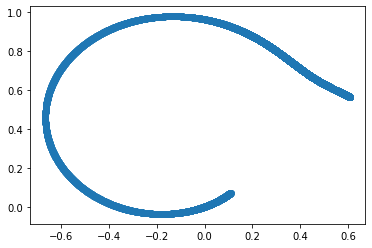

In [60]:
gr = create_polar_graph()
awrde.Project.Simulator.Analyze()
meas_vals = get_meas_vals(gr)
freqs, real, imag = np.asarray(meas_vals)
plot_polar(real, imag)
cpx = real + imag*1j

In [61]:
delete_graph(gr)

True

In [62]:
def do_stuff():

    gr = create_polar_graph()
    awrde.Project.Simulator.Analyze()
    meas_vals = get_meas_vals(gr)
    freqs, real, imag = np.asarray(meas_vals)
    plot_polar(real, imag)
    cpx = real + imag*1j
    delete_graph(gr)

    circ = cf.reflection_port(freqs, cpx)
    circ.autofit()
    circ.plotall()
    print(circ.fitresults)

    return circ

In [63]:
def is_fit_good(circ):
    fit_good = False

    if circ.Ql>0 and circ.Qc>0 and circ.Qi>0:
        print("Qs all positive.")

        if circ.f_data[0] < circ.fr < circ.f_data[-1]:
            print("fr in f_data")
            fit_good = True
        
        else:
            fit_good = False

    else:
        fit_good = False
    
    return fit_good

[0.22887872 0.22888093 0.22888311 ... 0.599141   0.59916881 0.59919661]
[0.22413528 0.22407924 0.22402317 ... 0.60088089 0.60085801 0.60083513]


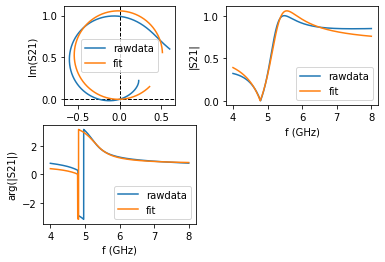

{'delay': -2.6587822268113144e-13, 'delay_remaining': -5.1450351133455685e-12, 'a': 0.6514666630716168, 'alpha': 0.680169913377306, 'theta': 2.915503685304314, 'phi': -0.9062588816627852, 'fr': 5264403625.244457, 'Ql': 7.057740988024133, 'Qc': 14.11077345008893, 'Qc_no_dia_corr': 8.702044484611475, 'Qi': 14.120193645367117, 'Qi_no_dia_corr': 37.351240915146576, 'fr_err': 1878949.9554906876, 'Ql_err': 0.03300881838867019, 'absQc_err': 0.0392780700947979, 'phi_err': 0.002132668817576054, 'Qi_err': 0.0849145270425336, 'Qi_no_dia_corr_err': 0.37783401053446974, 'chi_square': 0.010298297810165929}
Qs all positive.
fr in f_data
[0.16902158 0.16907143 0.16912129 ... 0.65997817 0.66001034 0.66004251]
[0.27366645 0.27367364 0.27368079 ... 0.55167489 0.55164888 0.55162286]


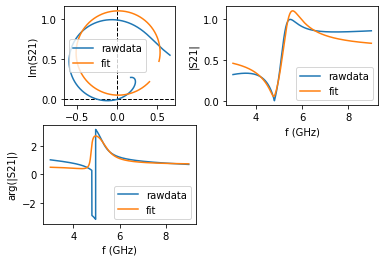

{'delay': -5.451364785992718e-13, 'delay_remaining': -1.0754719957094306e-11, 'a': 0.6153266216955983, 'alpha': 0.617257900495263, 'theta': 2.7055230804529167, 'phi': -1.0533274736321392, 'fr': 5334112218.707168, 'Ql': 7.0066224731624756, 'Qc': 16.557203894618663, 'Qc_no_dia_corr': 8.190550252468665, 'Qi': 12.146912505257736, 'Qi_no_dia_corr': 48.472630230996295, 'fr_err': 3347707.4306689873, 'Ql_err': 0.06041856295258048, 'absQc_err': 0.06375503466501294, 'phi_err': 0.004658354518858624, 'Qi_err': 0.14912415555831535, 'Qi_no_dia_corr_err': 1.456370821014243, 'chi_square': 0.03824506917510068}
Qs all positive.
fr in f_data


[ 0.20047415  0.20048568  0.2004972  ... -0.31321302 -0.31352854
 -0.31384412]
[0.27064582 0.27064109 0.27063636 ... 0.02521484 0.02535845 0.02550235]


D:\serge\Documents\Koubit Lab\koubit-research\ResonatorSensitivity\awrde\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)
D:\serge\Documents\Koubit Lab\koubit-research\ResonatorSensitivity\awrde\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


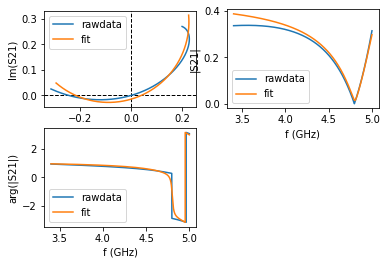

{'delay': -2.1190487790009136e-14, 'delay_remaining': -1.3537453091753025e-11, 'a': 0.46775251438695, 'alpha': 1.1369290832309409, 'theta': -2.6959732409915356, 'phi': -0.6913096706326831, 'fr': 5064024065.047158, 'Ql': 8.336353442224711, 'Qc': 16.038119558168795, 'Qc_no_dia_corr': 12.355954949545422, 'Qi': 17.35958105878719, 'Qi_no_dia_corr': 25.625328129671757, 'fr_err': 2207245.598768116, 'Ql_err': 0.032892379590226006, 'absQc_err': 0.03220442010653176, 'phi_err': 0.00470655223839904, 'Qi_err': 0.08396196024766858, 'Qi_no_dia_corr_err': 0.2583361257978229, 'chi_square': 0.003682059745011619}
Qs all positive.


[0.51483779 0.51485481 0.51487182 ... 0.63753629 0.63754573 0.63755517]
[0.67501216 0.67499608 0.67498002 ... 0.56975097 0.56974338 0.56973579]


D:\serge\Documents\Koubit Lab\koubit-research\ResonatorSensitivity\awrde\lib\site-packages\scipy\optimize\minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


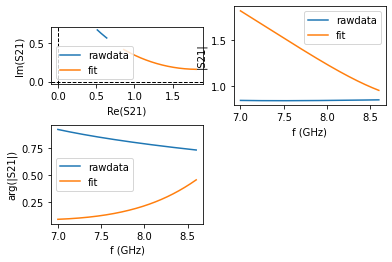

{'delay': -1.0441764662064545e-13, 'delay_remaining': -5.986070414610767e-11, 'a': 4.671308051021617, 'alpha': 0.8743399263239644, 'theta': -2.226492667662793, 'phi': 0.04076005960303597, 'fr': 8974008015.481441, 'Ql': 0.7576878344881316, 'Qc': 1.8507205208052724, 'Qc_no_dia_corr': 1.8491833563363826, 'Qi': 1.2829153612747761, 'Qi_no_dia_corr': 1.2836550446505652, 'fr_err': 10916437692.841864, 'Ql_err': 0.5720392239127698, 'absQc_err': 13.542843490976287, 'phi_err': 1.86255305545358, 'Qi_err': 7.96375143788189, 'Qi_no_dia_corr_err': 7.911314805589815, 'chi_square': 0.036783232644361556}
Qs all positive.


[0.17834447 0.17828598 0.17822744 ... 0.44967031 0.44970318 0.44973604]
[0.10960416 0.10953651 0.10946884 ... 0.73866678 0.73863428 0.73860179]


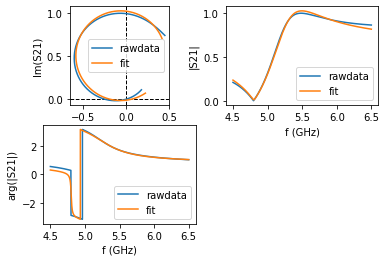

{'delay': -2.703209349745746e-13, 'delay_remaining': -5.217158120508425e-12, 'a': 0.6304209271506458, 'alpha': 0.759530011271418, 'theta': 3.0051995698375347, 'phi': -0.8959230950236763, 'fr': 5234297480.527226, 'Ql': 7.7726868255368355, 'Qc': 15.110293638979346, 'Qc_no_dia_corr': 9.440886425905337, 'Qi': 16.00625153183782, 'Qi_no_dia_corr': 43.98817355418038, 'fr_err': 757165.2005032634, 'Ql_err': 0.012055784063407706, 'absQc_err': 0.013717860978204405, 'phi_err': 0.0007855537849076283, 'Qi_err': 0.03215760343081276, 'Qi_no_dia_corr_err': 0.15474892747470403, 'chi_square': 0.0018368674280882387}
Qs all positive.
fr in f_data


True

In [70]:
reset_freqs()
ds = do_stuff()
is_fit_good(ds)

reset_freqs(3e9, 9e9, 10000)
ds = do_stuff()
is_fit_good(ds)

reset_freqs(3.4e9, 5e9, 10000)
ds = do_stuff()
is_fit_good(ds)

reset_freqs(7e9, 8.6e9, 10000)
ds = do_stuff()
is_fit_good(ds)

reset_freqs(4.5e9, 6.5e9, 10000)
ds = do_stuff()
is_fit_good(ds)


In [65]:
from sympy import Symbol, diff, exp, cos, pi, lambdify

class analyze_circuit(cf.circuit):
    '''
    Circlefit class for finding the exact derivative of Sij and maximizing it.
    '''

    n_ports = None
    f_data = None

    def __init__(self, circ):
        self.n_ports = circ.n_ports
        self.f_data = circ.f_data

    def sensitive_Sij(self, fr, Ql, Qc, phi=0., a=1., alpha=0., delay=0.):
        '''
        Returns the frequency at which the magnitude of the derivative of Sij is maximized.
        '''

        f = Symbol('f', real=True)

        complexQc = Qc*cos(phi)*exp(-1j*phi)
        S = a*exp(1j*(alpha-2*pi*f*delay)) * (
            1. - 2.*Ql / (complexQc * self.n_ports * (1. + 2j*Ql*(f/fr-1.)))
        )

        ds = diff(S, f)
        ds_np = lambdify(f, ds, 'numpy')
        #NOTE: I'm just maximizing the magnititude of the derivatives of Sij here... Complex numbers have no ordering
        ds_mags = np.asarray(np.abs(ds_np(self.f_data)))
        arg = np.argmax(ds_mags)

        return self.f_data[arg]




In [66]:
new_circ = analyze_circuit(ds)
max = new_circ.sensitive_Sij(ds.fr, ds.Ql, ds.Qc, ds.phi, ds.a, ds.alpha, ds.delay)

In [67]:
def fit_circ(circ_type='reflection_port'):

    gr = create_polar_graph()
    awrde.Project.Simulator.Analyze()
    meas_vals = get_meas_vals(gr)
    freqs, real, imag = np.asarray(meas_vals)
    plot_polar(real, imag)
    cpx = real + imag*1j
    delete_graph(gr)

    if circ_type == 'reflection_port':
        circ = cf.reflection_port(freqs, cpx)
        circ.autofit()
        circ.plotall()
        print(circ.fitresults)
    
    elif circ_type == 'notch_port':
        circ = cf.notch_port(freqs, cpx)
        circ.autofit()
        circ.plotall()
        print(circ.fitresults)

    else:
        print("Invalid circuit measurement mode! Must be 'reflection' or 'notch'.")

    return circ

In [ ]:
def bin_search(freq_arr, circ_type='reflection_port', debug=False):
    steps = 10000

    def left_search():

        if debug:
            print('left search')

        l_bnd = freq_arr[0]
        u_bnd = freq_arr[np.shape(freq_arr)[0]//2]

        reset_freqs(l_bnd, u_bnd, steps)
        circ = fit_circ(circ_type)

        return circ

    def right_search():

        if debug:
            print('right search')

        l_bnd = freq_arr[np.shape(freq_arr)[0]//2]
        u_bnd = freq_arr[-1]
        
        reset_freqs(l_bnd, u_bnd, steps)
        circ = fit_circ(circ_type)

        return circ

    def check_fit(circ):
        if debug:
            print('frequency bounds: ' + (freq_arr[0], freq_arr[-1], steps).__str__())
            print('resonant freqency: ' + str(circ.fr))
        
        if is_fit_good(circ):
            three_db_bw = circ.fr/circ.Ql

            if 3.5 * three_db_bw < freq_arr[-1] - freq_arr[0] < 4.5 * three_db_bw:
                if debug:
                   print('3.5 * three_db_bw ({}) < freq_arr[-1] ({}) - freq_arr[0] ({}) < 4.5 * three_db_bw ({})'.format(3.5*three_db_bw, freq_arr[-1] - freq_arr[0]), 4.5 * three_db_bw) 
                
                return is_fit_good(circ) and circ.f_data[0] < circ.fr < circ.f_data[-1]

            elif 3.5 * three_db_bw >= freq_arr[-1] - freq_arr[0]:
                if freq_arr[0] - 5e8 > 0:    
                    reset_freqs(freq_arr[0] - 5e8, freq_arr[-1] + 1e9)

            elif freq_arr[-1] - freq_arr[0] <= 5e8:
                if debug:
                    print('')
                    print('Pruned branch.')

                return False
        
        else:
            return False
    
    l_test_circ = left_search()
    r_test_circ = right_search()
    circs = (l_test_circ, r_test_circ)

    for ci in circs:
        if check_fit(ci):
            new_circ = analyze_circuit(ci)
            max = new_circ.sensitive_Sij(ci.fr, ci.Ql, ci.Qc, ci.phi, ci.a, ci.alpha, ci.delay)

            return max
        
        else:
            if debug:
                print('Searching: bin_search' + (ci.f_data, circ_type, debug).__str__())
                
            bin_search(ci.f_data, circ_type, debug)

In [ ]:
def search_ideal(circ, circ_type='reflection_port', debug=False):
    steps = 10000
    new_freqs = circ.f_data
    circuit_type = circ_type
    current_circuit = circ

    def move_left(incr = 5e8):        
        if debug:
            print('Moving left.')
            
        if new_freqs[0] - incr >= 0:
            current_circuit = fit_circ(circuit_type)
            return reset_freqs(new_freqs[0] - incr, new_freqs[-1] - incr)

    def move_right(incr = 5e8):
        if debug:
            print('Moving right.')

        if new_freqs[-1] <= 10e9:
            current_circuit = fit_circ(circuit_type)
            return reset_freqs(new_freqs[0] + incr, new_freqs[-1] + incr)
    
    def split(circ):
        if debug:
            print('Splitting.')

        l_bnd = new_freqs[0]
        u_bnd = new_freqs[np.shape(new_freqs)[0]//2]
        reset_freqs(l_bnd, u_bnd)
        v1 = search_ideal(fit_circ(circuit_type), circuit_type, debug)
        l_bnd = new_freqs[np.shape(new_freqs)[0]//2]
        u_bnd = new_freqs[-1]
        reset_freqs(l_bnd, u_bnd)
        v2 = search_ideal(fit_circ(circuit_type), circuit_type, debug)

        return max(v1, v2)
    
    def fine_tune(circ):
        if debug:
            print('Fine tuning.')

        current_circuit = circ
        current_circuit.autofit()
        cc_fr_err = current_circuit.fitresults.get('fr_err')
        move_left()
        current_circuit.autofit()

        if cc_fr_err < current_circuit.fitresults.get('fr_err'):
            move_right()
            move_right()
            current_circuit.autofit()

            if cc_fr_err < current_circuit.fitresults.get('fr_err'):
                move_left()
                return current_circuit


        return fine_tune(current_circuit)
        
    def expand(incr = 5e8):
        if debug:
            print('Expanding.')
        if new_freqs[-1] + incr <= 10e9:
            new_freqs = reset_freqs(new_freqs[0], new_freqs[-1] + incr)
        if freq_arr[0] + incr >= 0:
            new_freqs = reset_freqs(new_freqs[0] - incr, new_freqs[-1])
            
        current_circuit = fit_circ(circ, circuit_type)
        return new_freqs

    def contract(incr = 5e8):
        if debug:
            print('Contracting.')
        if new_freqs[-1] - new_freqs[0] > 3*incr:
            new_freqs = reset_freqs(new_freqs[0] + incr, new_freqs[-1] - incr)
            current_circuit = fit_circ(circuit_type)
            return new_freqs

    def check_roll_off():
        phase = np.unwrap(np.angle(circ.z_data))
        if np.max(phase) - np.min(phase) <= 0.8*2*np.pi:
            if debug:
                print('Roll-off is less than ~2pi. Expanding bounds.')
            
            expand()
            return check_roll_off()
        
        else:
            return new_freqs

    def check_bw():
        three_db_bw = circ.fr/circ.Ql

        if debug:
            print('checking bandwidth.')
            text = f'3.5 * three_db_bw ({3.5*three_db_bw}) < new_freqs[-1] ({new_freqs[-1]}) - new_freqs[0] ({new_freqs[0]}) < 4.5 * three_db_bw ({4.5 * three_db_bw})'
            print(text)
        
        if new_freqs[-1] - new_freqs[0] > 5.*three_db_bw:
            contract()
            return check_roll_off()
        elif new_freqs[-1] - new_freqs[0] < 3.*three_db_bw:
            expand()
            return check_roll_off()
        else:
            return new_freqs
        
    def get_max_deriv(circ):
        new_circ = analyze_circuit(circ)
        max = new_circ.sensitive_Sij(circ.fr, circ.Ql, circ.Qc, circ.phi, circ.a, circ.alpha, circ.delay)
        return max

    def check_fit(circ):
        if debug:
            print('frequency bounds: ' + (new_freqs[0], new_freqs[-1], steps).__str__())
            print('resonant freqency: ' + str(circ.fr))
        
        check_bw()

        if is_fit_good(circ):
            return fine_tune(circ)
        else:
            return split(circ)
    
    return get_max_deriv(check_fit(circ))

In [ ]:
reset_freqs(2e9, 12e9)
circuit = fit_circ('reflection_port')
search_ideal(circuit, debug=True)